In [22]:
# ============================================================================
# 导入所有必需的库和模块
# ============================================================================

# 基础库
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# API 和模型
from ambiguity_detection_utils import AmbiguityDetector
from ollama import Client
from prompts import DISAMBIGUATION_PROMPT_TEMPLATE

# 深度学习模型
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

# 机器学习评估指标
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, 
    precision_recall_curve, auc,
    confusion_matrix, classification_report, 
    accuracy_score
)

print("所有库导入完成！")

所有库导入完成！


In [23]:
# ============================================================================
# 创建检测器和加载数据
# ============================================================================

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

Semantic歧义统计:
  有semantic歧义: 2831 (22.0%)
  无semantic歧义: 10016 (78.0%)
平衡测试集: 5662 个用户故事
  HasAmbiguity=True: 2831 (50.0%)
  HasAmbiguity=False: 2831 (50.0%)
测试数据集: 5662 个用户故事


In [24]:
df_test = df_test.sample(n=100, random_state=7)
df_test.head()

,StoryID,StoryText,HasAmbiguity
968,US-C1-1106,"As a investor, I would like to schedule appoin...",False
5183,US-C1-144,"As a account holder, I want to view account ba...",False
3065,US-C4-8139,"As a service representative, I need to handle ...",True
949,US-C4-7771,"As a network admin, I would like to pay bill t...",False
2853,US-C2-3204,"As a patient, I would like to handle patient c...",True


In [25]:
df_test.count()

StoryID         100
StoryText       100
HasAmbiguity    100
dtype: int64

In [26]:
client = Client(
    host="http://2yo6159kw603.vicp.fun/",
)

In [27]:
prompt_template = DISAMBIGUATION_PROMPT_TEMPLATE

In [28]:
# 遍历df_test中的每个StoryText，使用prompt_template进行推理，并将结果存储为列表
results = []

for no, (index, row) in enumerate(df_test.iterrows()):
    story_text = row['StoryText']
    formatted_prompt = prompt_template.format(REQUIREMENT=story_text)
    
    try:
        response = client.chat(model='gpt-oss:20b', messages=[
            {
                'role': 'user',
                'content': formatted_prompt,
            },
        ])
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': response.message.content
        })
        print(f"Processed story {no + 1}/{len(df_test)}: {row['StoryID']}")
    except Exception as e:
        print(f"Error processing story {row['StoryID']}: {str(e)}")
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': f"Error: {str(e)}"
        })

print(f"\nCompleted processing {len(results)} stories.")

Processed story 1/100: US-C1-1106
Processed story 2/100: US-C1-144
Processed story 3/100: US-C4-8139
Processed story 4/100: US-C4-7771
Processed story 5/100: US-C2-3204
Processed story 6/100: US-C8-12775
Processed story 7/100: US-C4-8562
Processed story 8/100: US-C3-5306
Processed story 9/100: US-C5-9552
Processed story 10/100: US-C3-6093
Processed story 11/100: US-C4-7904
Processed story 12/100: US-C2-3708
Processed story 13/100: US-C4-7344
Processed story 14/100: US-C2-2846
Processed story 15/100: US-C2-3905
Processed story 16/100: US-C2-4133
Processed story 17/100: US-C2-2421
Processed story 18/100: US-C3-5281
Processed story 19/100: US-C7-11661
Processed story 20/100: US-C6-11038
Processed story 21/100: US-C3-5528
Processed story 22/100: US-C4-7083
Processed story 23/100: US-C2-3485
Processed story 24/100: US-C7-11507
Processed story 25/100: US-C5-10056
Processed story 26/100: US-C2-3154
Processed story 27/100: US-C2-2468
Processed story 28/100: US-C4-7289
Processed story 29/100: U

In [41]:
formatted_prompt = prompt_template.format(REQUIREMENT="Results will be arranged in length/date/alphabetical order by clicking on the column headers.")
    
response = client.chat(model='gpt-oss:20b', messages=[
    {
        'role': 'user',
        'content': formatted_prompt,
    },
])
results.append({
            'StoryID': "test",
            'StoryText': "Results will be arranged in length/date/alphabetical order by clicking on the column headers.",
            'HasAmbiguity': False,
            'Disambiguation': response.message.content
        })

In [43]:
response.message.content

'**Disambiguations:**\n\n1. As an end‑user, I want clicking on the **Length** column header to sort results in ascending or descending numeric order (toggling each click) so that I can quickly find the shortest or longest items.\n\n2. As an end‑user, I want clicking on the **Date** column header to sort results chronologically (newest first on first click, oldest first on the second click) so that I can view the most recent or earliest entries without confusion.\n\n3. As an end‑user, I want clicking on the **Alphabetical** column header to sort results alphabetically by name (case‑insensitive) and display a visual indicator of the current sort direction so that I can navigate the list efficiently.\n\n4. As an end‑user, I want the ability to hold **Shift** while clicking a second column header (e.g., Length then Date) so that the list is sorted first by the primary column and then by the secondary column, enabling multi‑level sorting for more precise results.\n\n5. As a system administr

In [44]:
# 解析消歧结果，将每个用户故事的消歧项转换为列表格式
parsed_results = []

for result in results:
    story_id = result['StoryID']
    story_text = result['StoryText']
    disambiguation_text = result['Disambiguation']
    
    # 解析消歧项
    disambiguations = []
    if disambiguation_text.startswith('Disambiguations:'):
        # 移除开头的'Disambiguations:'
        content = disambiguation_text[len('Disambiguations:'):].strip()
        # 按行分割
        lines = content.split('\n')
        for line in lines:
            line = line.strip()
            # 检查是否是以数字开头的消歧项
            if line and (line.startswith('1. ') or line.startswith('2. ') or line.startswith('3. ') 
                         or line.startswith('4. ') or line.startswith('5. ') or line.startswith('6. ') 
                         or line.startswith('7. ') or line.startswith('8. ') or line.startswith('9. ') 
                         or line.startswith('10. ')):
                # 提取消歧项内容（去掉序号）
                disambiguation = line.split('. ', 1)[1].strip()
                disambiguations.append(disambiguation)
    
    parsed_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'Disambiguations': disambiguations
    })

# 显示解析后的结果
for parsed_result in parsed_results:
    print(f"用户故事: {parsed_result['StoryID']}")
    print(f"故事文本: {parsed_result['StoryText']}")
    print("消歧项列表:")
    for i, disambiguation in enumerate(parsed_result['Disambiguations'], 1):
        print(f"  {i}. {disambiguation}")
    print()

用户故事: US-C1-1106
故事文本: As a investor, I would like to schedule appointment to save time with detailed specifications and comprehensive requirements
消歧项列表:
  1. As an investor, I want to schedule an appointment with a portfolio manager through a web portal so that I can quickly book a convenient time slot without lengthy back‑and‑forth, ensuring the appointment details (date, time, duration) are auto‑filled and a confirmation email is sent.
  2. As an investor, I want to set up recurring quarterly review meetings with my advisor, where the system automatically adjusts the schedule based on my specified preferences and provides a detailed agenda with required documents, so that I save time preparing each meeting.
  3. As an investor, I want to schedule a one‑on‑one call with a broker using an AI‑powered assistant that suggests optimal times based on both parties’ calendars and provides a pre‑call checklist of detailed investment specifications (e.g., target assets, risk tolerance), so th

In [45]:
# 过滤掉澄清项为空的结果
parsed_results_filtered = [result for result in parsed_results if result['Disambiguations']]

print(f"原始结果数量: {len(parsed_results)}")
print(f"过滤后结果数量: {len(parsed_results_filtered)}")
print(f"已过滤掉的结果: {len(parsed_results) - len(parsed_results_filtered)}")

# 更新parsed_results为过滤后的结果
parsed_results = parsed_results_filtered

print("\n过滤完成，现在parsed_results只包含有澄清项的结果")

原始结果数量: 101
过滤后结果数量: 86
已过滤掉的结果: 15

过滤完成，现在parsed_results只包含有澄清项的结果


In [46]:
# 1. 加载预训练的BERT模型和分词器
model_name = "rambodazimi/bert-base-uncased-finetuned-FFT-QQP"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# 设置设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()  # 设置为评估模式

print(f"BERT模型已加载到 {device}")
print(f"模型名称: {model_name}")

BERT模型已加载到 cuda
模型名称: rambodazimi/bert-base-uncased-finetuned-FFT-QQP


In [47]:
# 2. 定义获取句子嵌入的函数
def get_sentence_embedding(text, tokenizer, model, device, max_length=512):
    """
    获取文本的BERT嵌入向量
    
    参数:
        text: 输入文本
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备 (cuda or cpu)
        max_length: 最大文本长度
    
    返回:
        embedding: 句子嵌入向量 (1, 768)
    """
    # 将文本转换为模型可接受的输入格式
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=max_length
    )
    
    # 将输入移到相同的设备上
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # 不计算梯度，加快推理速度
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 对最后一个隐藏层的所有标记向量求平均
    embedding = torch.mean(outputs.last_hidden_state, dim=1)
    
    return embedding.cpu().numpy()

print("get_sentence_embedding 函数已定义")

get_sentence_embedding 函数已定义


In [48]:
# 4. 定义计算 Clarification Score 的函数（核心方法）
def calculate_clarification_score(clarifications, tokenizer, model, device):
    """
    计算澄清批次的歧义分数
    
    公式: g(C_i^(q)) = ∑_{(c_ij, c_ij') ∈ C_i^(q) × C_i^(q)} (1 - sim(c_ij, c_ij'))
    
    该分数衡量澄清之间的语义分散程度。高分表示澄清之间差异大，
    说明原始查询具有高度歧义。低分表示澄清之间相似，说明原始查询较为明确。
    
    参数:
        clarifications: 澄清文本列表
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备
    
    返回:
        score: 澄清分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)
    """
    n = len(clarifications)
    
    if n < 2:
        # 如果少于2个澄清，无法计算分数
        return 0.0, np.array([[1.0]])
    
    # 1. 获取所有澄清的嵌入向量
    embeddings = []
    for clarification in clarifications:
        embedding = get_sentence_embedding(clarification, tokenizer, model, device)
        embeddings.append(embedding)
    
    embeddings = np.vstack(embeddings)  # (n, 768)
    
    # 2. 计算所有澄清对的相似度矩阵
    similarity_matrix = cosine_similarity(embeddings)  # (n, n)
    
    # 3. 计算分数：所有非对角线相似度倒数和
    score = 0.0
    pair_count = 0
    
    for i in range(n):
        for j in range(n):
            if i != j:  # 不包括自身相似度
                dissimilarity = 1 - similarity_matrix[i][j]
                score += dissimilarity
                pair_count += 1
    
    return score, similarity_matrix

print("calculate_clarification_score 函数已定义")

calculate_clarification_score 函数已定义


In [49]:
# 5. 处理解析后的结果，计算每个用户故事的 Clarification Score
clarification_scores = []

for idx, parsed_result in enumerate(parsed_results):
    story_id = parsed_result['StoryID']
    story_text = parsed_result['StoryText']
    disambiguations = parsed_result['Disambiguations']
    
    # 如果有澄清项，计算分数；否则分数为0
    if len(disambiguations) > 1:
        score, similarity_matrix = calculate_clarification_score(
            disambiguations, 
            tokenizer, 
            bert_model, 
            device
        )
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
    
    clarification_scores.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'NumClarifications': len(disambiguations),
        'ClarificationScore': score,
        'AmbiguityLevel': 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
    })
    
    print(f"已处理 {idx + 1}/{len(parsed_results)}: {story_id}")
    print(f"  澄清数: {len(disambiguations)}, 分数: {score:.4f}, 歧义级别: {clarification_scores[-1]['AmbiguityLevel']}")

# 创建DataFrame用于分析
scores_df = pd.DataFrame(clarification_scores)
print(f"\n完成处理 {len(clarification_scores)} 个用户故事")
print("\n澄清分数统计:")
print(scores_df[['NumClarifications', 'ClarificationScore', 'AmbiguityLevel']].describe())

已处理 1/86: US-C1-1106
  澄清数: 10, 分数: 2.5375, 歧义级别: Medium
已处理 2/86: US-C1-144
  澄清数: 10, 分数: 5.1279, 歧义级别: High
已处理 3/86: US-C4-8139
  澄清数: 10, 分数: 4.3249, 歧义级别: Medium
已处理 4/86: US-C4-7771
  澄清数: 10, 分数: 3.0167, 歧义级别: Medium
已处理 5/86: US-C2-3204
  澄清数: 10, 分数: 4.8407, 歧义级别: Medium
已处理 6/86: US-C8-12775
  澄清数: 10, 分数: 4.1625, 歧义级别: Medium
已处理 7/86: US-C4-8562
  澄清数: 10, 分数: 4.7432, 歧义级别: Medium
已处理 8/86: US-C3-5306
  澄清数: 10, 分数: 3.4660, 歧义级别: Medium
已处理 9/86: US-C5-9552
  澄清数: 10, 分数: 6.6759, 歧义级别: High
已处理 10/86: US-C3-6093
  澄清数: 10, 分数: 4.6366, 歧义级别: Medium
已处理 11/86: US-C4-7904
  澄清数: 10, 分数: 4.6464, 歧义级别: Medium
已处理 12/86: US-C2-3708
  澄清数: 10, 分数: 6.6640, 歧义级别: High
已处理 13/86: US-C4-7344
  澄清数: 10, 分数: 2.9815, 歧义级别: Medium
已处理 14/86: US-C2-2846
  澄清数: 10, 分数: 4.5509, 歧义级别: Medium
已处理 15/86: US-C2-3905
  澄清数: 10, 分数: 5.4437, 歧义级别: High
已处理 16/86: US-C2-4133
  澄清数: 10, 分数: 4.6450, 歧义级别: Medium
已处理 17/86: US-C7-11661
  澄清数: 10, 分数: 4.7426, 歧义级别: Medium
已处理 18/86: US-C6-11038
  澄清数: 

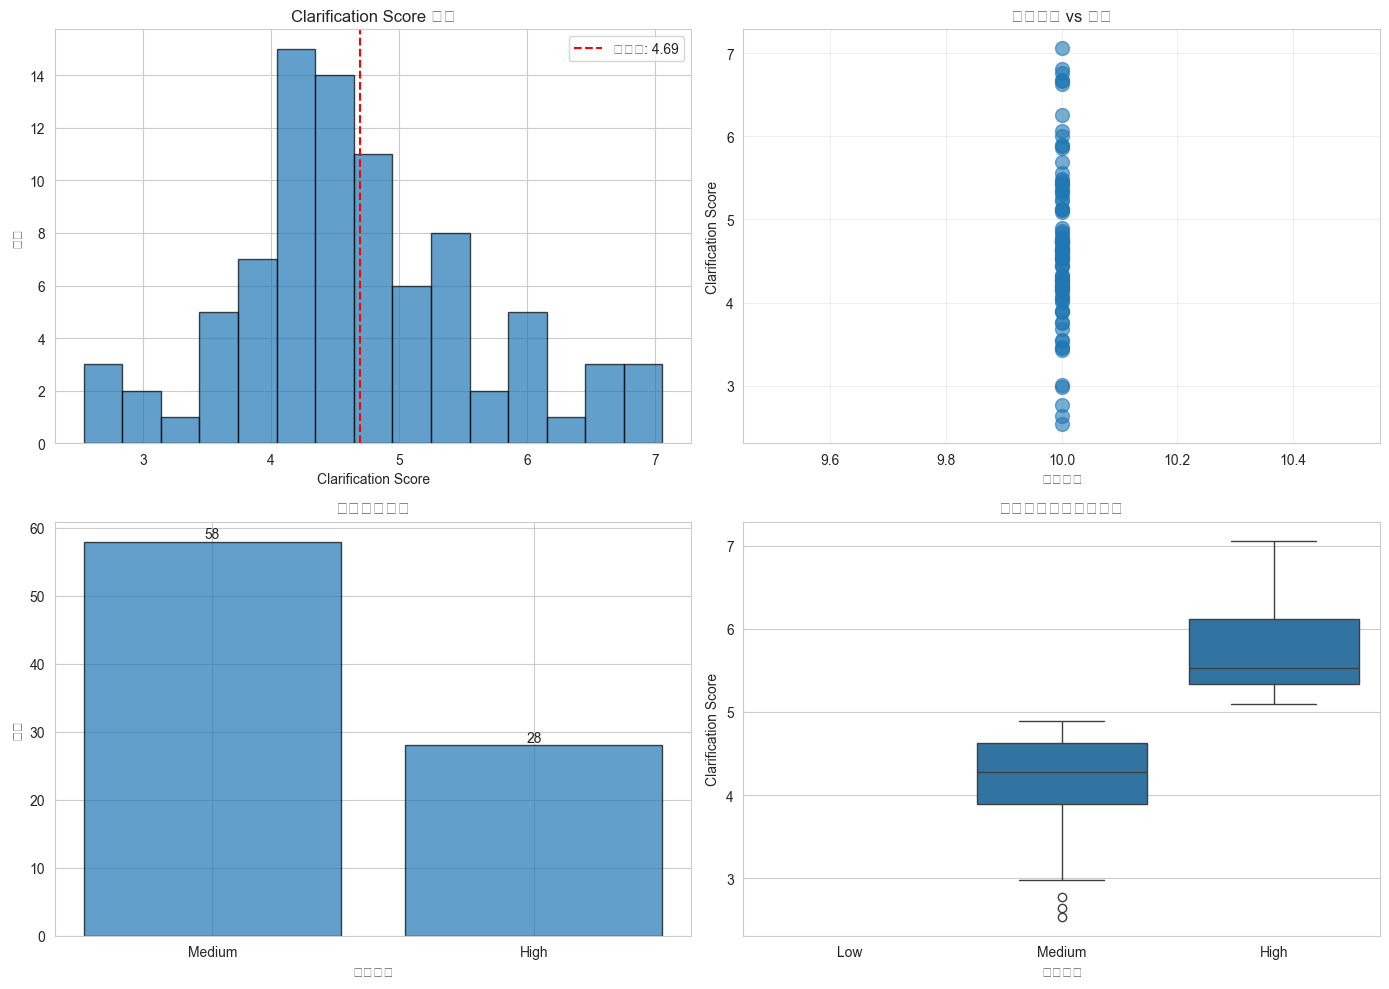

分析结果已保存到 clarification_score_analysis.png


In [50]:
# 6. 可视化分析结果
# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Clarification Score 分布直方图
axes[0, 0].hist(scores_df['ClarificationScore'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Clarification Score')
axes[0, 0].set_ylabel('频率')
axes[0, 0].set_title('Clarification Score 分布')
axes[0, 0].axvline(scores_df['ClarificationScore'].mean(), color='red', linestyle='--', label=f'平均值: {scores_df["ClarificationScore"].mean():.2f}')
axes[0, 0].legend()

# 2. 澄清数量 vs 分数散点图
axes[0, 1].scatter(scores_df['NumClarifications'], scores_df['ClarificationScore'], alpha=0.6, s=100)
axes[0, 1].set_xlabel('澄清数量')
axes[0, 1].set_ylabel('Clarification Score')
axes[0, 1].set_title('澄清数量 vs 分数')
axes[0, 1].grid(True, alpha=0.3)

# 3. 歧义级别分布
ambiguity_counts = scores_df['AmbiguityLevel'].value_counts()
axes[1, 0].bar(ambiguity_counts.index, ambiguity_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('歧义级别')
axes[1, 0].set_ylabel('数量')
axes[1, 0].set_title('歧义级别分布')
for i, v in enumerate(ambiguity_counts.values):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom')

# 4. 评分箱线图（按歧义级别）
order = ['Low', 'Medium', 'High']
scores_df_sorted = scores_df.copy()
scores_df_sorted['AmbiguityLevel'] = pd.Categorical(scores_df_sorted['AmbiguityLevel'], categories=order, ordered=True)
sns.boxplot(data=scores_df_sorted, x='AmbiguityLevel', y='ClarificationScore', ax=axes[1, 1])
axes[1, 1].set_xlabel('歧义级别')
axes[1, 1].set_ylabel('Clarification Score')
axes[1, 1].set_title('各歧义级别的分数分布')

plt.tight_layout()
plt.savefig('clarification_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("分析结果已保存到 clarification_score_analysis.png")

In [51]:
# 8. 计算 AUROC 和 F1 分数用于评估歧义检测性能
# 合并 df_test 的真实标签和 scores_df 的预测分数
# 创建一个映射字典，将 StoryID 与 HasAmbiguity 对应
true_labels_dict = dict(zip(df_test['StoryID'], df_test['HasAmbiguity']))

# 为 scores_df 添加真实标签
scores_df['TrueLabel'] = scores_df['StoryID'].map(true_labels_dict)

# 移除没有真实标签的行
scores_df_with_labels = scores_df.dropna(subset=['TrueLabel'])

print(f"用于评估的样本数: {len(scores_df_with_labels)}")
print(f"真实标签分布:")
print(scores_df_with_labels['TrueLabel'].value_counts())
print()

# 准备数据
y_true = scores_df_with_labels['TrueLabel'].astype(int).values
y_scores = scores_df_with_labels['ClarificationScore'].values

# 1. 计算 AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"消歧方法 - AUROC: {auroc:.4f}")

# 获取ROC曲线的FPR和TPR
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# 2. 寻找最优的阈值（使用约登指数）
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"最优阈值（基于约登指数）: {optimal_threshold:.4f}")

# 3. 使用最优阈值进行二分类
y_pred = (y_scores >= optimal_threshold).astype(int)

# 4. 计算 F1 分数
f1 = f1_score(y_true, y_pred)
print(f"消歧方法 - F1 Score: {f1:.4f}")

# 5. 计算其他评估指标（用于可视化和后续分析，但不在主要输出中突出）
accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc:.4f}")
print(f"  F1 Score: {f1:.4f}\n")
print("="*50)

用于评估的样本数: 86
真实标签分布:
TrueLabel
False    43
True     43
Name: count, dtype: int64

消歧方法 - AUROC: 0.5176
最优阈值（基于约登指数）: 5.8585
消歧方法 - F1 Score: 0.3273


总结:
  AUROC: 0.5176
  F1 Score: 0.3273



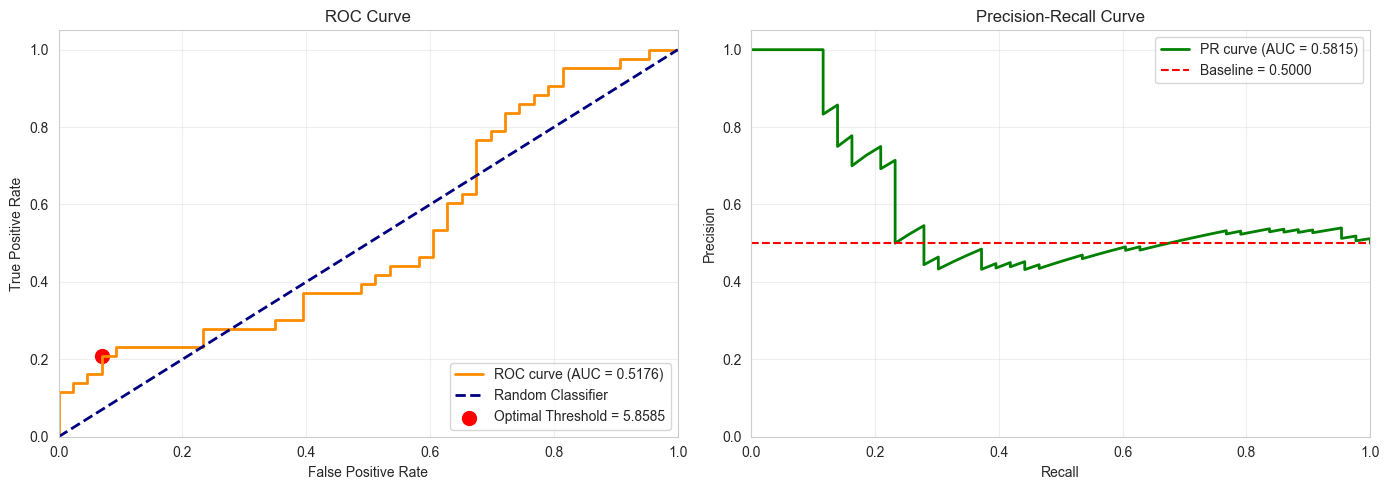

评估曲线已保存到 ambiguity_detection_evaluation.png

PR-AUC (Precision-Recall AUC): 0.5815


In [52]:
# 9. 可视化 ROC 曲线和 Precision-Recall 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 曲线
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auroc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
                label=f'Optimal Threshold = {optimal_threshold:.4f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_true) / len(y_true), color='red', linestyle='--', 
                label=f'Baseline = {np.sum(y_true) / len(y_true):.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ambiguity_detection_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("评估曲线已保存到 ambiguity_detection_evaluation.png")
print(f"\nPR-AUC (Precision-Recall AUC): {pr_auc:.4f}")

In [53]:
scores_df.sort_values(by='ClarificationScore', ascending=False, inplace=True)

In [54]:
scores_df.head()

,StoryID,StoryText,NumClarifications,ClarificationScore,AmbiguityLevel,TrueLabel
83,US-C2-3618,"As a user, I want to update system in order to...",10,7.058426,High,True
33,US-C7-12073,"As a shopper, I would like to manage products ...",10,6.813399,High,True
58,US-C5-9787,"As a account holder, I need to process applica...",10,6.758456,High,True
8,US-C5-9552,"As a customer, I want to manage account in ord...",10,6.675869,High,True
11,US-C2-3708,"As a healthcare provider, I want to manage hea...",10,6.664032,High,True


In [55]:
scores_df.tail()

,StoryID,StoryText,NumClarifications,ClarificationScore,AmbiguityLevel,TrueLabel
3,US-C4-7771,"As a network admin, I would like to pay bill t...",10,3.016695,Medium,False
12,US-C4-7344,"As a service representative, I want to trouble...",10,2.981547,Medium,False
27,US-C8-12518,"As a engineer, I want to manage operations in ...",10,2.776075,Medium,True
78,US-C3-5915,"As a seller, I want to add to cart so that I c...",10,2.644050,Medium,False
0,US-C1-1106,"As a investor, I would like to schedule appoin...",10,2.537506,Medium,False
